In [58]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, classification_report
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE

import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from app.assets import preprocessing

In [59]:
data = preprocessing.load_processed_data()

df_customer = data['customer']
df_order = data['order']
df_geo = data['geo']
df_order_item = data['order_item']
df_product = data['product']
df_order_payment = data['order_payment']
df_order_review = data['order_review']
df_seller = data['seller']

/Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/app/assets/preprocessing.py:303: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'order': pd.read_csv(DATA_PROCESSED_DIR / 'order.csv', parse_dates=['purchase_timestamp', 'approved_timestamp', 'delivered_carrier_date', 'delivered_customer_date', 'purchase_month']),


# Delay Predictions and Consequences

- Is there a relationship between delays and product dimensions?
- Do customers drop off spending after delayed orders?
- Which product categories are most likely to experience delays?
- In which product categories do delays account for lower following sales/lower reviews?

### What are the top product dimension/category candidates for regression analysis?


In [60]:
# Merge tables

prod_dim_cols = ['weight', 'length','height','width', 'category_name']

orders_cols = ['delayed', 'order_id']

df_order_item_orders = df_order_item.merge(df_order[orders_cols])

selection = df_order_item_orders[prod_dim_cols + ['delayed']]

In [61]:
# One-hot encode category_name column

ohe = OneHotEncoder(sparse_output=False)

encoded = ohe.fit_transform(selection['category_name'].to_numpy().reshape(-1,1))

category_cols = ohe.get_feature_names_out()

category_cols_stripped = [col.strip('x0_') for col in category_cols]

encoded_df = pd.DataFrame(encoded, columns=category_cols_stripped)

selection = selection.drop(columns='category_name')

# Full df for regression analysis
full_selection_df = pd.concat((selection, encoded_df), axis=1).dropna()


In [62]:
# Extract features and target

predict_cols = ['weight', 'length','height','width'] + category_cols_stripped

X = full_selection_df[predict_cols].to_numpy()
y = full_selection_df['delayed']

In [63]:
# F-Regression to find most salient features

f, p = f_regression(X,y)

zipped = list(zip(f,p,predict_cols))
feature_df = pd.DataFrame(zipped, columns=['F-statistic', 'p-value','feature'])

In [64]:
print("Percentage of P-values below 5%: ", len(p < .05) / len(p) * 100)

Percentage of P-values below 5%:  100.0


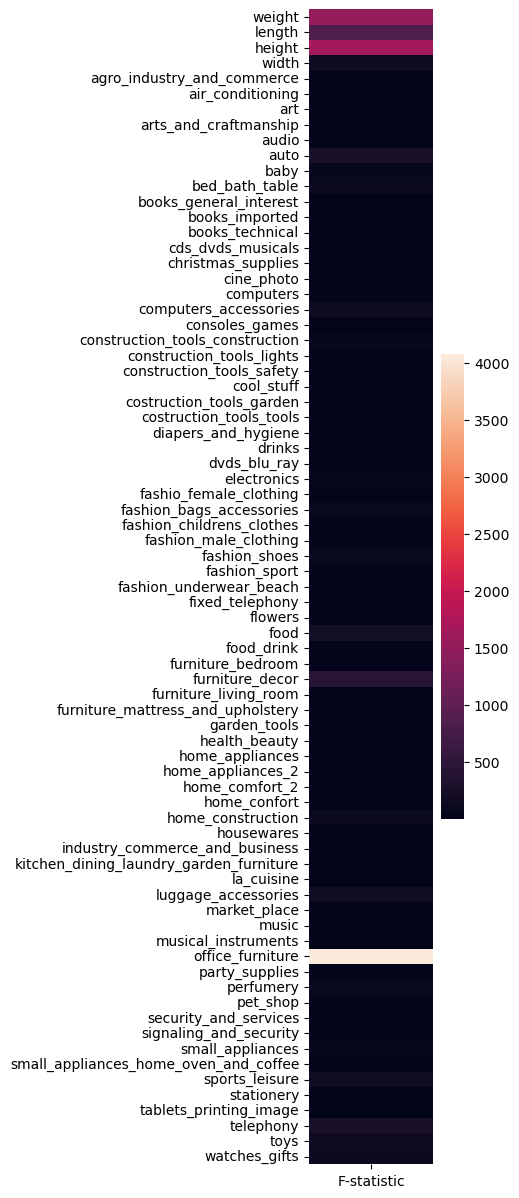

In [65]:
# Plot most salient features

ax = plt.subplot()
fig = ax.get_figure()
fig.set_size_inches(2, 15)
sns.heatmap(feature_df.iloc[:,:1], yticklabels=feature_df.iloc[:,2], ax=ax)
plt.show()


In [66]:
# Gather top 10 features

top_10_features = feature_df.sort_values('F-statistic', ascending=False).head(10)['feature']
print("Top 10 Features From Univariate Regressions: \n", top_10_features.values)

Top 10 Features From Univariate Regressions: 
 ['office_furniture' 'height' 'weight' 'length' 'furniture_decor' 'auto'
 'telephony' 'food' 'luggage_accessories' 'sports_leisure']


### Are the product dimension relationships linear?

In [67]:
top_10_features = list(top_10_features.values)

X = full_selection_df[top_10_features].dropna().to_numpy()
y = full_selection_df['delayed']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [72]:
dummy = DummyClassifier(strategy="most_frequent", random_state=0)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_dummy))

Baseline accuracy: 0.5907742346658462


In [ ]:
def run_log_reg(X, y):
    df = full_selection_df[[X, y]].dropna() 
    feature = df[[X]].to_numpy()             
    target = df[y].to_numpy()                

    logreg = LogisticRegression()
    logreg.fit(feature, target)

    coef = logreg.coef_
    odds_ratio = float(np.exp(coef)[0, 0])
    return logreg.coef_, odds_ratio

results = []
for feature in top_10_features:
    coef, odds_ratio = run_log_reg(feature, 'delayed')
    results.append((feature, coef[0,0], odds_ratio, ))

for f, beta, or_, in results:
    print(f"{f:20s} beta = {beta: .3f}, OR = {or_: .3f}")



office_furniture     beta =  3.124, OR =  22.746
height               beta =  0.015, OR =  1.015
weight               beta =  0.000, OR =  1.000
length               beta =  0.009, OR =  1.009
furniture_decor      beta =  0.364, OR =  1.440
auto                 beta = -0.489, OR =  0.613
telephony            beta =  0.431, OR =  1.539
food                 beta = -1.362, OR =  0.256
luggage_accessories  beta = -0.912, OR =  0.402
sports_leisure       beta = -0.279, OR =  0.757


> **Takeaway:** 
> - Office furniture orders have about 22.7× higher odds of being delayed than non–office furniture orders.
> - Furniture décor orders have about 44% higher odds of being delayed than non-furniture décor orders.
> - Auto orders have about 39% lower odds of being delayed than non-auto orders.
> - Telephony orders have about 54% higher odds of being delayed than other orders.
> - For each 1 cm increase in height, the odds of delay increase by about 1.5%.
> - For each 1 cm increase in length, the odds of delay increase by about .9%
> - Food orders have about 74% lower odds of being delayed than non-food orders.
> - Luggage accessory orders have about 60% lower odds of being delayed than non-luggage orders.
> - Sports and leisure items have about 24% lower odds of being delayed than non-sports items.

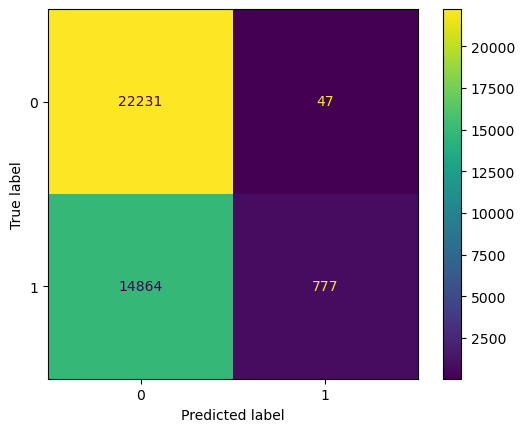

In [167]:
df = full_selection_df[['office_furniture', 'delayed']].dropna() 
feature = df['office_furniture'].to_numpy().reshape(-1,1)         
target = df['delayed'].to_numpy()                

X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state=42)


logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc = list(zip(fpr,tpr, thresholds))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prs = list(zip(precision, recall, thresholds))

In [169]:
for fpr, tpr, threshold in roc:
    print(f"Threshold: {threshold} - TPR: {tpr}, FPR: {fpr}\n")

print('Precision: tp / (tp + fp)')
print('Recall: tp / (tp + fn)')
print()
for precision, recall, threshold in prs:
    print(f"Threshold: {threshold} - Precision: {precision}, Recall: {recall}\n")


Threshold: inf - TPR: 0.0, FPR: 0.0

Threshold: 1.0 - TPR: 0.04967713061824691, FPR: 0.002109704641350211

Threshold: 0.0 - TPR: 1.0, FPR: 1.0

Precision: tp / (tp + fp)
Recall: tp / (tp + fn)

Threshold: 0 - Precision: 0.41248450644795487, Recall: 1.0

Threshold: 1 - Precision: 0.9429611650485437, Recall: 0.04967713061824691



In [ ]:
mask = df['office_furniture'] == 1
print("Percentage of Office Furniture: ", len(df[mask]['office_furniture']) / len(df))
print("Percentage of non-Office Furniture: ",len(df[~mask]['office_furniture']) / len(df))


Percentage of Office Furniture:  0.022053587911073605
Percentage of non-Office Furniture:  0.9779464120889264


In [71]:
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



In [75]:
pd.Series(y_train).value_counts(), pd.DataFrame(X_train).value_counts()

(0    67031
 1    46726
 Name: count, dtype: int64,
 0  
 0.0    111236
 1.0      2521
 Name: count, dtype: int64)

In [76]:
pd.Series(y_resampled).value_counts(), pd.DataFrame(X_resampled).value_counts()

(0    67031
 1    67031
 Name: count, dtype: int64,
 0  
 0.0    130552
 1.0      3510
 Name: count, dtype: int64)

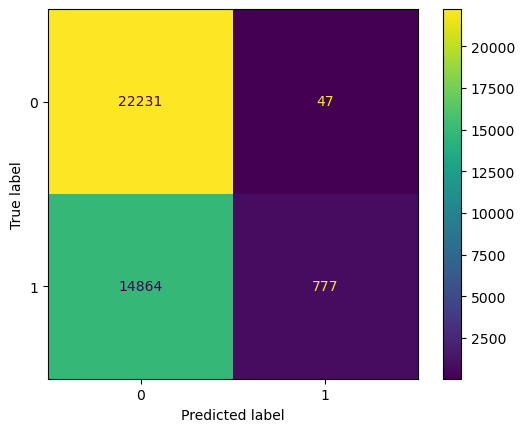

In [86]:
logreg_smote = LogisticRegression(class_weight='balanced')

logreg_smote.fit(X_resampled, y_resampled)

y_pred_resampled = logreg_smote.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_resampled)

In [ ]:
def run_random_forests(X, y):

    
    df = full_selection_df[[X,y]]
    feature = df[X].dropna().to_numpy().reshape(-1,1)
    target = df[y].dropna().to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(feature,target)

    logreg = RandomForestClassifier()
    logreg.fit(X_train,y_train)

    y_pred = logreg.predict(X_test)

    print(f"{X.upper()} X {y.upper()} RandomForest accuracy: {accuracy_score(y_pred, y_test): .2f} \n")

for feature in features:
    run_random_forests(feature, 'delayed')

OFFICE_FURNITURE X DELAYED RandomForest accuracy:  0.61

HEIGHT X DELAYED RandomForest accuracy:  0.61

WEIGHT X DELAYED RandomForest accuracy:  0.62

LENGTH X DELAYED RandomForest accuracy:  0.61

FURNITURE_DECOR X DELAYED RandomForest accuracy:  0.59

AUTO X DELAYED RandomForest accuracy:  0.59

TELEPHONY X DELAYED RandomForest accuracy:  0.59

FOOD X DELAYED RandomForest accuracy:  0.59

LUGGAGE_ACCESSORIES X DELAYED RandomForest accuracy:  0.59

SPORTS_LEISURE X DELAYED RandomForest accuracy:  0.59



In [ ]:

Xy = df_order_item[['weight','freight_value']].dropna()
X = np.array(Xy['weight']).reshape(-1,1)
y = np.array(Xy['freight_value']).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)


In [ ]:
over_30_000 = Xy['weight'] >= 30000
Xy_under_30_000 = Xy[~over_30_000]
X = np.array(Xy_under_30_000['weight']).reshape(-1,1)
y = np.array(Xy_under_30_000['freight_value']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

linreg = LinearRegression()


linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

loss = mean_absolute_error(y_test, y_pred)

r2_score(y_test, y_pred)

0.3327404293289631

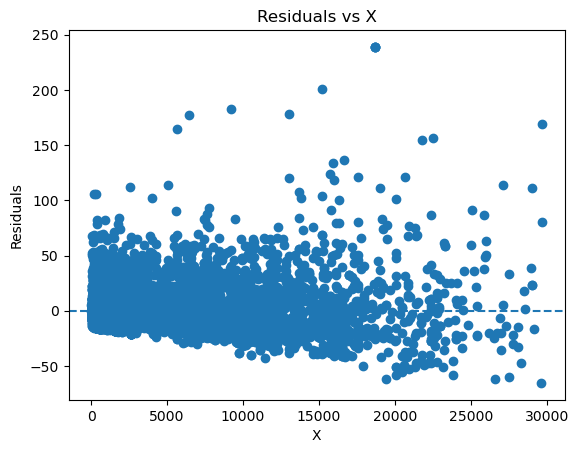

In [ ]:
residuals = y_test - y_pred

plt.scatter(X_test, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("X")
plt.ylabel("Residuals")
plt.title("Residuals vs X")
plt.show()

In [ ]:
Xy = Xy[over_30_000]
X = np.array(Xy['weight']).reshape(-1,1)
y = np.array(Xy['freight_value']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

linreg = LinearRegression()


linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

loss = mean_absolute_error(y_test, y_pred)

r2_score(y_test, y_pred)

0.0281908408428464

In [ ]:
X_for_test = y_pred

lin_resid = LinearRegression()
lin_resid.fit(X_for_test, residuals)

print("Residual slope:", lin_resid.coef_[0])
print("R^2 of residual ~ predicted:", lin_resid.score(X_for_test, residuals))

ValueError: Found input variables with inconsistent numbers of samples: [71, 27685]

In [ ]:
X = np.asarray(X).reshape(-1, 1)
X_quad = np.hstack([X, X**2])  # add quadratic term

model2 = LinearRegression().fit(X_quad, y)
y_pred2 = model2.predict(X_quad)

print("R^2 quadratic:", model2.score(X_quad, y))

R^2 quadratic: 0.33400292391450837


In [ ]:
cols = ['volume', 'price', 'freight_value', 'weight', 'length', 'width']

xyz = df_order_item[cols]

features = ['price', 'weight']
target = ['freight_value']
xyz_dropped = xyz.dropna()
X = xyz_dropped[features]
y = xyz_dropped[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
linreg = LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mae, r2)

residuals = y_test - y_pred
std = np.std(residuals, axis=0)  # residual std

# 95% two-sided error band, assuming approx Normal errors
z_95 = stats.norm.ppf(0.975)  # two-sided 95%
band_95 = z_95 * std


print("Residual std:", std)
print("Approx 95% error band: ±", band_95)
print("MAE:", mae)
print("MAE as fraction of error band:", mae / band_95)



6.686659954059651 0.41911815679748987
Residual std: freight_value    11.58889
dtype: float64
Approx 95% error band: ± freight_value    22.713808
dtype: float64
MAE: 6.686659954059651
MAE as fraction of error band: freight_value    0.294387
dtype: float64


# Product

- Are longer description lengths and more photos associated with higher sales? If so, how much more?